In [1]:
from mppi import MPPI

In [2]:
import mujoco
import mujoco_viewer
import copy as cp
import matplotlib.pyplot as plt

In [3]:
#import jax
import jax.numpy as jnp

In [4]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [5]:
model_sim = mujoco.MjModel.from_xml_path("../models/go1/go1_scene_jax_no_collision.xml")

In [6]:
model_sim.actuator('FR_hip').biasprm

array([  0., -40.,  -3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [7]:
model_sim.actuator('FL_calf').gainprm

array([40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [8]:
dt_sim = 0.01
model_sim.opt.timestep = dt_sim

data_sim = mujoco.MjData(model_sim)

In [9]:
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

In [10]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_init = cp.deepcopy(data_sim.qpos) # save reference pose
v_init = cp.deepcopy(data_sim.qvel) # save reference pose

In [11]:
print("Configuration: {}".format(q_init)) # save reference pose

Configuration: [ 0.     0.     0.08   1.     0.     0.     0.     0.073  1.34  -2.83
  0.073  1.34  -2.83   0.073  1.34  -2.83   0.073  1.34  -2.83 ]


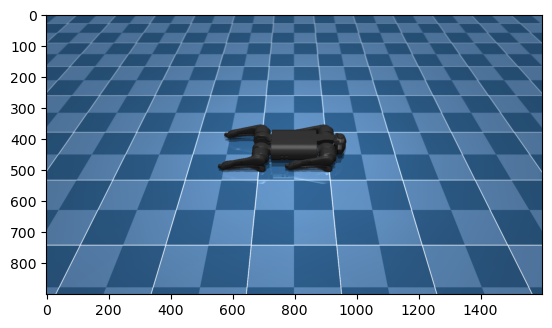

In [12]:
img = viewer.read_pixels()
plt.imshow(img)

In [13]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_ref_mj = cp.deepcopy(data_sim.qpos) # save reference pose
v_ref_mj = cp.deepcopy(data_sim.qvel) # save reference pose

In [14]:
print("Configuration: {}".format(q_ref_mj)) # save reference pose

Configuration: [ 0.          0.          0.27        0.70710678  0.          0.
  0.70710678  0.          0.9        -1.8         0.          0.9
 -1.8         0.          0.9        -1.8         0.          0.9
 -1.8       ]


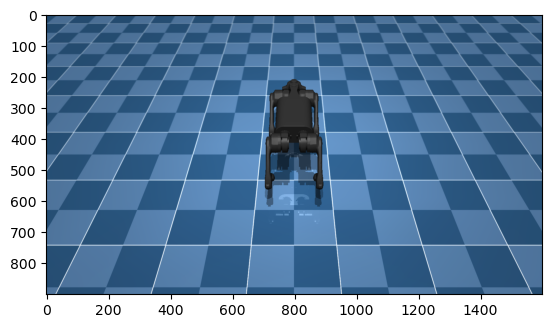

In [15]:
img = viewer.read_pixels()
plt.imshow(img)

In [25]:
controller_jax = MPPI()
controller_jax.reset_planner()

In [26]:
q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
x = jnp.concatenate([q_curr, v_curr])

In [27]:
%%time
controller_jax.update(x)

CPU times: user 33 ms, sys: 1.79 ms, total: 34.8 ms
Wall time: 13.3 ms


array([ 0.08403709,  1.32122529, -2.69890662,  0.07336287,  1.38892397,
       -2.81192419,  0.09653553,  1.34920553, -2.73678428,  0.0733938 ,
        1.36015134, -2.80484102])

In [28]:
controller_jax.reset_planner()

In [29]:
tfinal = 5
tvec = jnp.linspace(0,tfinal,int(jnp.ceil(tfinal/dt_sim))+1)

In [30]:
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1)
mujoco.mj_forward(model_sim, data_sim)

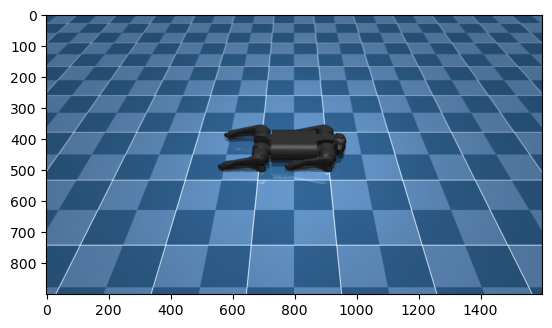

In [31]:
img = viewer.read_pixels()
plt.imshow(img)

In [32]:
%%time
anim_imgs = []
sim_inputs = []
for ticks, ti in enumerate(tvec):
    q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
    v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
    x = jnp.concatenate([q_curr, v_curr])
    u_joints = controller_jax.update(x)    
    data_sim.ctrl[:] = u_joints
    mujoco.mj_step(model_sim, data_sim)
    mujoco.mj_forward(model_sim, data_sim)
    img = viewer.read_pixels()
    anim_imgs.append(img)
    sim_inputs.append(u_joints)

CPU times: user 22.2 s, sys: 289 ms, total: 22.5 s
Wall time: 7.65 s


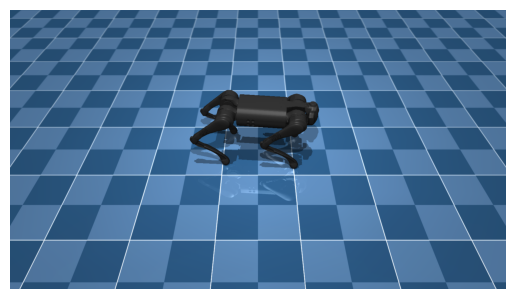

In [33]:
fig, ax = plt.subplots()
skip_frames = 10
interval = dt_sim*1000*skip_frames

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())